# **Hotel Stay Classifier**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

#### Calculating Durations

### **Data Preprocessing**

In [2]:
hotel_data = pd.read_csv('data/data.csv', low_memory=False)
hotel_data.head(10)

,BKG_DT,CK_IN_DT,CK_OUT_DT,LOC_DESC,GST_QTY,RM_QTY,RATE_SEGMENT,BKG_CHANNEL,STAY_PURPOSE
0,26/07/2022,27/07/2022,29/07/2022,LOC_7,1.0,1.0,RATE_6,NaN,BUSINESS
1,23/06/2022,28/07/2022,29/07/2022,LOC_7,1.0,1.0,RATE_5,NaN,BUSINESS
2,28/02/2021,04/03/2021,05/03/2021,LOC_6,2.0,1.0,RATE_8,NaN,BUSINESS
3,29/07/2022,31/07/2022,01/08/2022,LOC_7,2.0,1.0,RATE_6,NaN,BUSINESS
4,17/11/2021,20/11/2021,28/11/2021,LOC_7,1.0,1.0,RATE_6,NaN,BUSINESS
5,15/06/2022,05/08/2022,08/08/2022,LOC_7,1.0,1.0,RATE_5,NaN,LEISURE
6,03/08/2022,08/08/2022,17/08/2022,LOC_7,1.0,1.0,RATE_6,NaN,BUSINESS
7,08/08/2022,08/08/2022,12/08/2022,LOC_7,2.0,1.0,RATE_6,NaN,BUSINESS
8,03/08/2022,10/08/2022,12/08/2022,LOC_7,2.0,1.0,RATE_6,NaN,BUSINESS
9,09/08/2022,10/08/2022,11/08/2022,LOC_7,2.0,1.0,RATE_6,NaN,BUSINESS


In [3]:
hotel_data.shape

(585150, 9)

In [4]:
hotel_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 585150 entries, 0 to 585149
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   BKG_DT        516220 non-null  object 
 1   CK_IN_DT      516220 non-null  object 
 2   CK_OUT_DT     516220 non-null  object 
 3   LOC_DESC      515266 non-null  object 
 4   GST_QTY       516220 non-null  float64
 5   RM_QTY        516220 non-null  float64
 6   RATE_SEGMENT  514892 non-null  object 
 7   BKG_CHANNEL   516094 non-null  object 
 8   STAY_PURPOSE  516220 non-null  object 
dtypes: float64(2), object(7)
memory usage: 40.2+ MB


In [5]:
hotel_data.describe()

,GST_QTY,RM_QTY
count,516220.000000,516220.000000
mean,1.799938,1.000692
std,0.971818,0.040309
min,1.000000,1.000000
25%,1.000000,1.000000
50%,2.000000,1.000000
75%,2.000000,1.000000
max,99.000000,9.000000


In [6]:
hotel_data.isna().sum()

BKG_DT          68930
CK_IN_DT        68930
CK_OUT_DT       68930
LOC_DESC        69884
GST_QTY         68930
RM_QTY          68930
RATE_SEGMENT    70258
BKG_CHANNEL     69056
STAY_PURPOSE    68930
dtype: int64

### **Data Cleaning**

In [7]:
hotel_data = hotel_data.dropna(how='all')
hotel_data.isna().sum()

BKG_DT             0
CK_IN_DT           0
CK_OUT_DT          0
LOC_DESC         954
GST_QTY            0
RM_QTY             0
RATE_SEGMENT    1328
BKG_CHANNEL      126
STAY_PURPOSE       0
dtype: int64

In [8]:
hotel_data = hotel_data.dropna(subset=['LOC_DESC', 'RATE_SEGMENT', 'BKG_CHANNEL'])
hotel_data.isna().sum()

BKG_DT          0
CK_IN_DT        0
CK_OUT_DT       0
LOC_DESC        0
GST_QTY         0
RM_QTY          0
RATE_SEGMENT    0
BKG_CHANNEL     0
STAY_PURPOSE    0
dtype: int64

### **Identifying Column Types**

In [9]:
# Convert data fromat object to datetime

hotel_data['BKG_DT'] = pd.to_datetime(hotel_data['BKG_DT'],format='mixed')
hotel_data['CK_IN_DT'] = pd.to_datetime(hotel_data['CK_IN_DT'],format='mixed')
hotel_data['CK_OUT_DT'] = pd.to_datetime(hotel_data['CK_OUT_DT'],format='mixed')

hotel_data[['BKG_DT','CK_IN_DT','CK_OUT_DT']].head(10)

,BKG_DT,CK_IN_DT,CK_OUT_DT
126,2021-01-03,2021-02-03,2021-03-03
127,2021-02-23,2021-02-03,2021-04-03
128,2021-02-24,2021-02-03,2021-04-03
129,2021-02-03,2021-02-03,2021-06-03
130,2021-01-24,2021-02-03,2021-04-03
131,2021-02-27,2021-02-03,2021-04-03
132,2021-02-03,2021-02-03,2021-03-03
133,2021-02-28,2021-02-03,2021-03-03
134,2021-02-03,2021-02-03,2021-03-03
135,2021-02-03,2021-02-03,2021-06-03


In [10]:
hotel_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 513814 entries, 126 to 516219
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   BKG_DT        513814 non-null  datetime64[ns]
 1   CK_IN_DT      513814 non-null  datetime64[ns]
 2   CK_OUT_DT     513814 non-null  datetime64[ns]
 3   LOC_DESC      513814 non-null  object        
 4   GST_QTY       513814 non-null  float64       
 5   RM_QTY        513814 non-null  float64       
 6   RATE_SEGMENT  513814 non-null  object        
 7   BKG_CHANNEL   513814 non-null  object        
 8   STAY_PURPOSE  513814 non-null  object        
dtypes: datetime64[ns](3), float64(2), object(4)
memory usage: 39.2+ MB


In [11]:
category_cols = [feature for feature in hotel_data.columns if hotel_data[feature].dtype == 'object']
numerical_cols = [feature for feature in hotel_data.columns if hotel_data[feature].dtype != 'object']

In [12]:
category_cols

['LOC_DESC', 'RATE_SEGMENT', 'BKG_CHANNEL', 'STAY_PURPOSE']

In [13]:
numerical_cols

['BKG_DT', 'CK_IN_DT', 'CK_OUT_DT', 'GST_QTY', 'RM_QTY']

In [14]:
for col in category_cols:
    print(hotel_data[col].value_counts())
    print('\n')

LOC_DESC
LOC_6    161105
LOC_7    156652
LOC_3     62501
LOC_5     61119
LOC_1     41132
LOC_4     31248
LOC_2        57
Name: count, dtype: int64


RATE_SEGMENT
RATE_8    314489
RATE_1     94787
RATE_6     53139
RATE_5     25786
RATE_4     16599
RATE_7      8831
RATE_2       169
RATE_3        14
Name: count, dtype: int64


BKG_CHANNEL
CHANNEL_6    245387
CHANNEL_4    102131
CHANNEL_5     90130
CHANNEL_1     47509
CHANNEL_2     25452
CHANNEL_3      3205
Name: count, dtype: int64


STAY_PURPOSE
LEISURE     351059
BUSINESS    162755
Name: count, dtype: int64




## **Data Visualization**

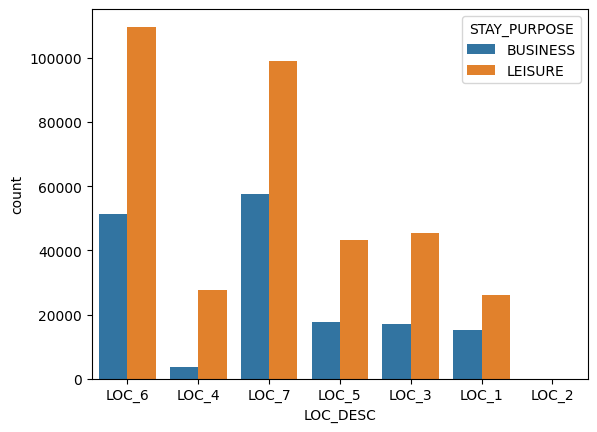

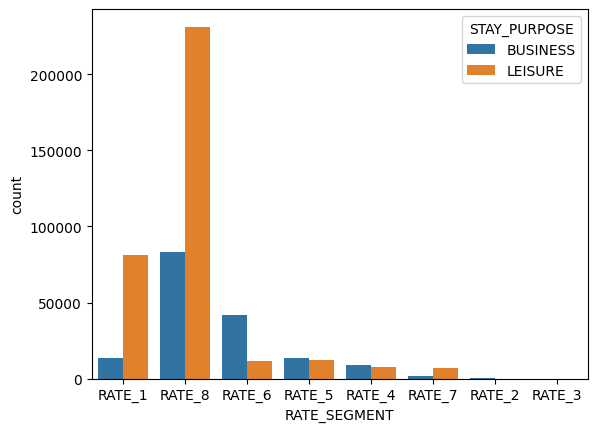

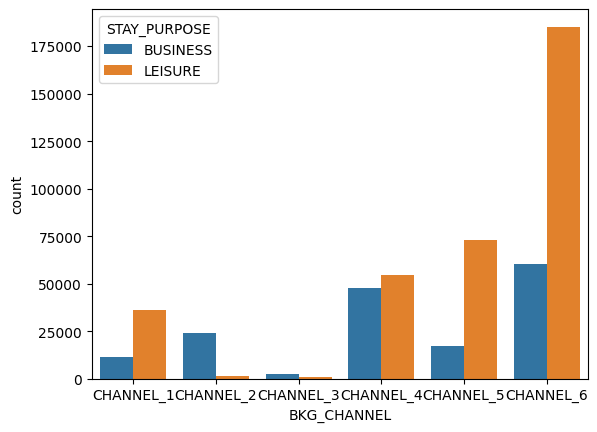

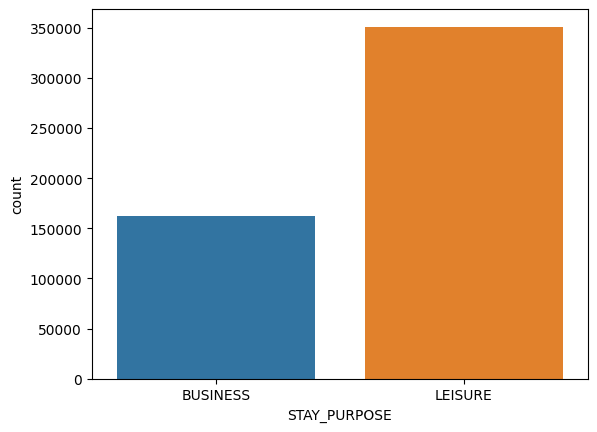

In [15]:
for col in category_cols:
        sns.countplot(x=col,hue='STAY_PURPOSE',data=hotel_data)
        plt.show()

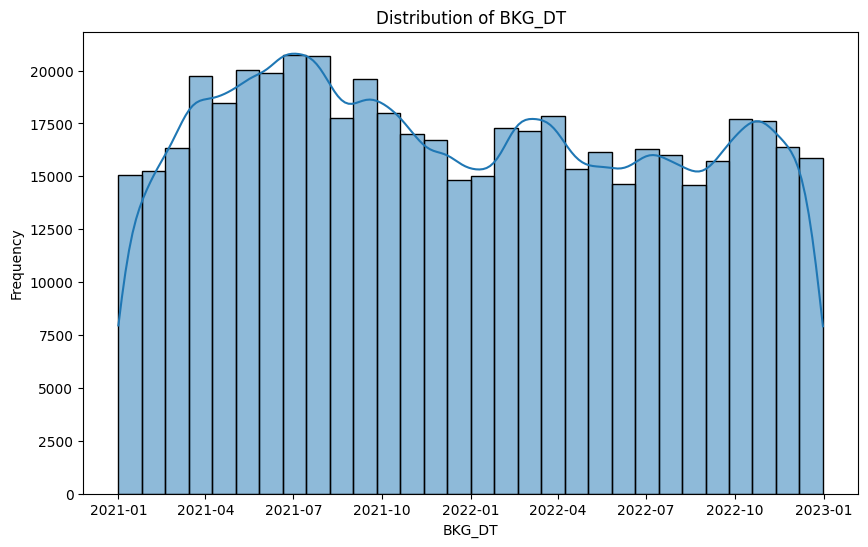

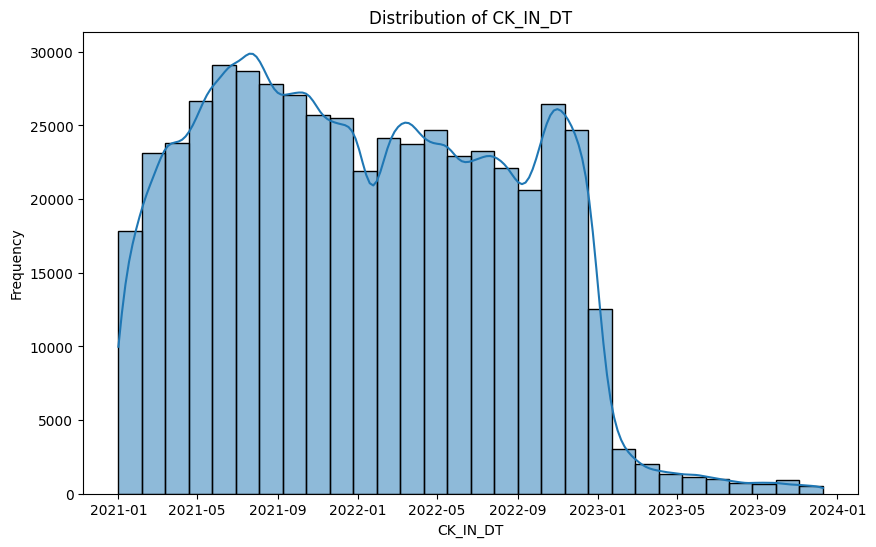

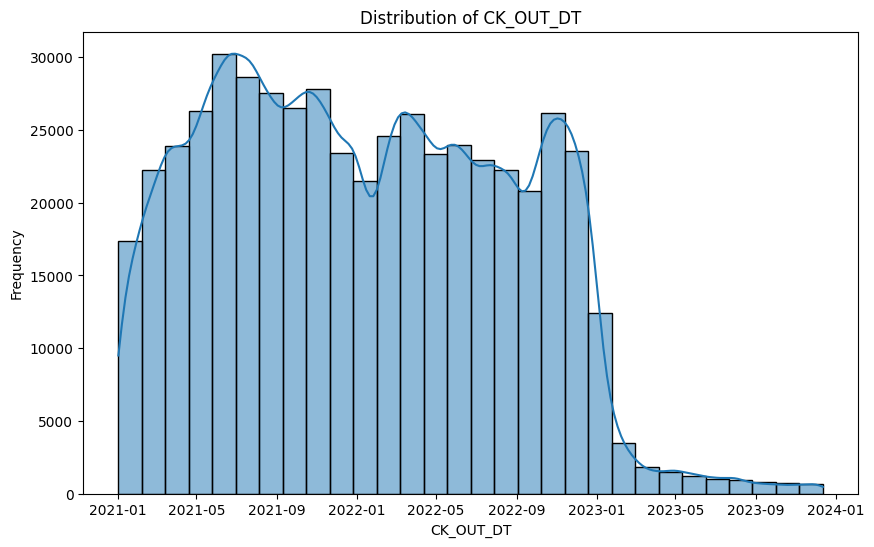

In [16]:
for col in ['BKG_DT','CK_IN_DT','CK_OUT_DT']:
    plt.figure(figsize=(10, 6))
    sns.histplot(hotel_data[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

## **Feature Engineering**

#### Calculating Durations

In [17]:
hotel_data['Length_of_Stay'] = (hotel_data['CK_OUT_DT'] - hotel_data['CK_IN_DT']).dt.days
hotel_data['Booking_Lead_Time'] = (hotel_data['CK_IN_DT'] - hotel_data['BKG_DT']).dt.days

#### Calculating Day

In [18]:
hotel_data['BKG_Day'] = hotel_data['BKG_DT'].dt.dayofweek 
hotel_data['CK_IN_Day'] = hotel_data['CK_IN_DT'].dt.dayofweek
hotel_data['CK_OUT_Day'] = hotel_data['CK_OUT_DT'].dt.dayofweek

#### Extract Month & Apply Seasons

In [19]:
hotel_data['BKG_Month'] = hotel_data['BKG_DT'].dt.month
hotel_data['CK_IN_Month'] = hotel_data['CK_IN_DT'].dt.month
hotel_data['CK_OUT_Month'] = hotel_data['CK_OUT_DT'].dt.month

In [20]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'
hotel_data['BKG_Season'] = hotel_data['BKG_Month'].apply(get_season)


In [21]:
hotel_data[['LOC_DESC', 'BKG_CHANNEL', 'BKG_Season']]
hotel_data = pd.get_dummies(hotel_data, columns=['LOC_DESC', 'BKG_CHANNEL', 'BKG_Season'])

In [22]:
label_encoder = LabelEncoder()
hotel_data['RATE_SEGMENT_encoded'] = label_encoder.fit_transform(hotel_data['RATE_SEGMENT'])

In [23]:
hotel_data.head(10)

,BKG_DT,CK_IN_DT,CK_OUT_DT,GST_QTY,RM_QTY,RATE_SEGMENT,STAY_PURPOSE,Length_of_Stay,Booking_Lead_Time,BKG_Day,...,BKG_CHANNEL_CHANNEL_2,BKG_CHANNEL_CHANNEL_3,BKG_CHANNEL_CHANNEL_4,BKG_CHANNEL_CHANNEL_5,BKG_CHANNEL_CHANNEL_6,BKG_Season_Fall,BKG_Season_Spring,BKG_Season_Summer,BKG_Season_Winter,RATE_SEGMENT_encoded
126,2021-01-03,2021-02-03,2021-03-03,2.0,1.0,RATE_1,BUSINESS,28,31,6,...,False,False,False,False,False,False,False,False,True,0
127,2021-02-23,2021-02-03,2021-04-03,2.0,1.0,RATE_1,LEISURE,59,-20,1,...,False,False,False,False,False,False,False,False,True,0
128,2021-02-24,2021-02-03,2021-04-03,3.0,1.0,RATE_8,BUSINESS,59,-21,2,...,False,False,False,False,False,False,False,False,True,7
129,2021-02-03,2021-02-03,2021-06-03,2.0,1.0,RATE_8,BUSINESS,120,0,2,...,False,False,False,False,False,False,False,False,True,7
130,2021-01-24,2021-02-03,2021-04-03,2.0,1.0,RATE_1,LEISURE,59,10,6,...,False,False,False,False,False,False,False,False,True,0
131,2021-02-27,2021-02-03,2021-04-03,1.0,1.0,RATE_6,BUSINESS,59,-24,5,...,False,False,False,False,False,False,False,False,True,5
132,2021-02-03,2021-02-03,2021-03-03,1.0,1.0,RATE_1,LEISURE,28,0,2,...,False,False,False,False,False,False,False,False,True,0
133,2021-02-28,2021-02-03,2021-03-03,3.0,1.0,RATE_8,LEISURE,28,-25,6,...,False,False,False,False,False,False,False,False,True,7
134,2021-02-03,2021-02-03,2021-03-03,2.0,1.0,RATE_8,LEISURE,28,0,2,...,False,False,False,False,False,False,False,False,True,7
135,2021-02-03,2021-02-03,2021-06-03,2.0,1.0,RATE_8,LEISURE,120,0,2,...,False,False,False,False,False,False,False,False,True,7


### **Drop unnesecary columns**

In [24]:
hotel_data = hotel_data.drop(['BKG_DT', 'CK_IN_DT', 'CK_OUT_DT', 'RATE_SEGMENT', 'RM_QTY', 'LOC_DESC_LOC_2', 'BKG_CHANNEL_CHANNEL_3'], axis=1)
hotel_data.head(10)

,GST_QTY,STAY_PURPOSE,Length_of_Stay,Booking_Lead_Time,BKG_Day,CK_IN_Day,CK_OUT_Day,BKG_Month,CK_IN_Month,CK_OUT_Month,...,BKG_CHANNEL_CHANNEL_1,BKG_CHANNEL_CHANNEL_2,BKG_CHANNEL_CHANNEL_4,BKG_CHANNEL_CHANNEL_5,BKG_CHANNEL_CHANNEL_6,BKG_Season_Fall,BKG_Season_Spring,BKG_Season_Summer,BKG_Season_Winter,RATE_SEGMENT_encoded
126,2.0,BUSINESS,28,31,6,2,2,1,2,3,...,True,False,False,False,False,False,False,False,True,0
127,2.0,LEISURE,59,-20,1,2,5,2,2,4,...,True,False,False,False,False,False,False,False,True,0
128,3.0,BUSINESS,59,-21,2,2,5,2,2,4,...,True,False,False,False,False,False,False,False,True,7
129,2.0,BUSINESS,120,0,2,2,3,2,2,6,...,True,False,False,False,False,False,False,False,True,7
130,2.0,LEISURE,59,10,6,2,5,1,2,4,...,True,False,False,False,False,False,False,False,True,0
131,1.0,BUSINESS,59,-24,5,2,5,2,2,4,...,True,False,False,False,False,False,False,False,True,5
132,1.0,LEISURE,28,0,2,2,2,2,2,3,...,True,False,False,False,False,False,False,False,True,0
133,3.0,LEISURE,28,-25,6,2,2,2,2,3,...,True,False,False,False,False,False,False,False,True,7
134,2.0,LEISURE,28,0,2,2,2,2,2,3,...,True,False,False,False,False,False,False,False,True,7
135,2.0,LEISURE,120,0,2,2,3,2,2,6,...,True,False,False,False,False,False,False,False,True,7


### **Encode the Y Value which is STAY_PURPOSE**

In [25]:
hotel_data['STAY_PURPOSE'] = hotel_data['STAY_PURPOSE'].apply(lambda x: 1 if x == 'BUSINESS' else 0)
hotel_data.head(10)

,GST_QTY,STAY_PURPOSE,Length_of_Stay,Booking_Lead_Time,BKG_Day,CK_IN_Day,CK_OUT_Day,BKG_Month,CK_IN_Month,CK_OUT_Month,...,BKG_CHANNEL_CHANNEL_1,BKG_CHANNEL_CHANNEL_2,BKG_CHANNEL_CHANNEL_4,BKG_CHANNEL_CHANNEL_5,BKG_CHANNEL_CHANNEL_6,BKG_Season_Fall,BKG_Season_Spring,BKG_Season_Summer,BKG_Season_Winter,RATE_SEGMENT_encoded
126,2.0,1,28,31,6,2,2,1,2,3,...,True,False,False,False,False,False,False,False,True,0
127,2.0,0,59,-20,1,2,5,2,2,4,...,True,False,False,False,False,False,False,False,True,0
128,3.0,1,59,-21,2,2,5,2,2,4,...,True,False,False,False,False,False,False,False,True,7
129,2.0,1,120,0,2,2,3,2,2,6,...,True,False,False,False,False,False,False,False,True,7
130,2.0,0,59,10,6,2,5,1,2,4,...,True,False,False,False,False,False,False,False,True,0
131,1.0,1,59,-24,5,2,5,2,2,4,...,True,False,False,False,False,False,False,False,True,5
132,1.0,0,28,0,2,2,2,2,2,3,...,True,False,False,False,False,False,False,False,True,0
133,3.0,0,28,-25,6,2,2,2,2,3,...,True,False,False,False,False,False,False,False,True,7
134,2.0,0,28,0,2,2,2,2,2,3,...,True,False,False,False,False,False,False,False,True,7
135,2.0,0,120,0,2,2,3,2,2,6,...,True,False,False,False,False,False,False,False,True,7


In [26]:
print("Class distribution:\n", hotel_data['STAY_PURPOSE'].value_counts())

Class distribution:
 STAY_PURPOSE
0    351059
1    162755
Name: count, dtype: int64


## **Model Implementation**

In [27]:
X = hotel_data.drop(columns=['STAY_PURPOSE'], axis=1)
y = hotel_data['STAY_PURPOSE']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=42)

## **Logistic Regression**

In [28]:
param_grid = {
    'lr__C': [0.001,0.01], 
    'lr__max_iter': [100], 
    'lr__penalty': ['l2'], 
    'lr__solver': ['liblinear']
}
logRegression = LogisticRegression()
pipeline_lr = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('lr', logRegression)    
])

grid_search_lr = GridSearchCV(estimator=pipeline_lr, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_lr.fit(X_train, y_train) 

prediction_data_lr = grid_search_lr.predict(X_test)
train_accuracy_lr = accuracy_score(y_train, grid_search_lr.predict(X_train))
test_accuracy_lr = accuracy_score(y_test, prediction_data_lr)

print("Best parameters found: ", grid_search_lr.best_params_)
print("Best cross-validation accuracy: {:.3f}".format(grid_search_lr.best_score_))
print("Training accuracy: {:.3f}".format(train_accuracy_lr))
print("Test accuracy: {:.3f}".format(test_accuracy_lr))

if train_accuracy_lr < test_accuracy_lr and test_accuracy_lr < grid_search_lr.best_score_:
    print("Underfitting: The model may be too simple for the data.")
elif train_accuracy_lr > test_accuracy_lr:
    print("Overfitting: The model may be overfitting to the training data.")
else:
    print("Good fit: The model seems to generalize well.")

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best parameters found:  {'lr__C': 0.01, 'lr__max_iter': 100, 'lr__penalty': 'l2', 'lr__solver': 'liblinear'}
Best cross-validation accuracy: 0.790
Training accuracy: 0.790
Test accuracy: 0.788
Overfitting: The model may be overfitting to the training data.


In [29]:
print("Classification report:", classification_report(y_test, prediction_data_lr))

Classification report:               precision    recall  f1-score   support

           0       0.81      0.90      0.85     87697
           1       0.72      0.55      0.62     40757

    accuracy                           0.79    128454
   macro avg       0.76      0.72      0.74    128454
weighted avg       0.78      0.79      0.78    128454



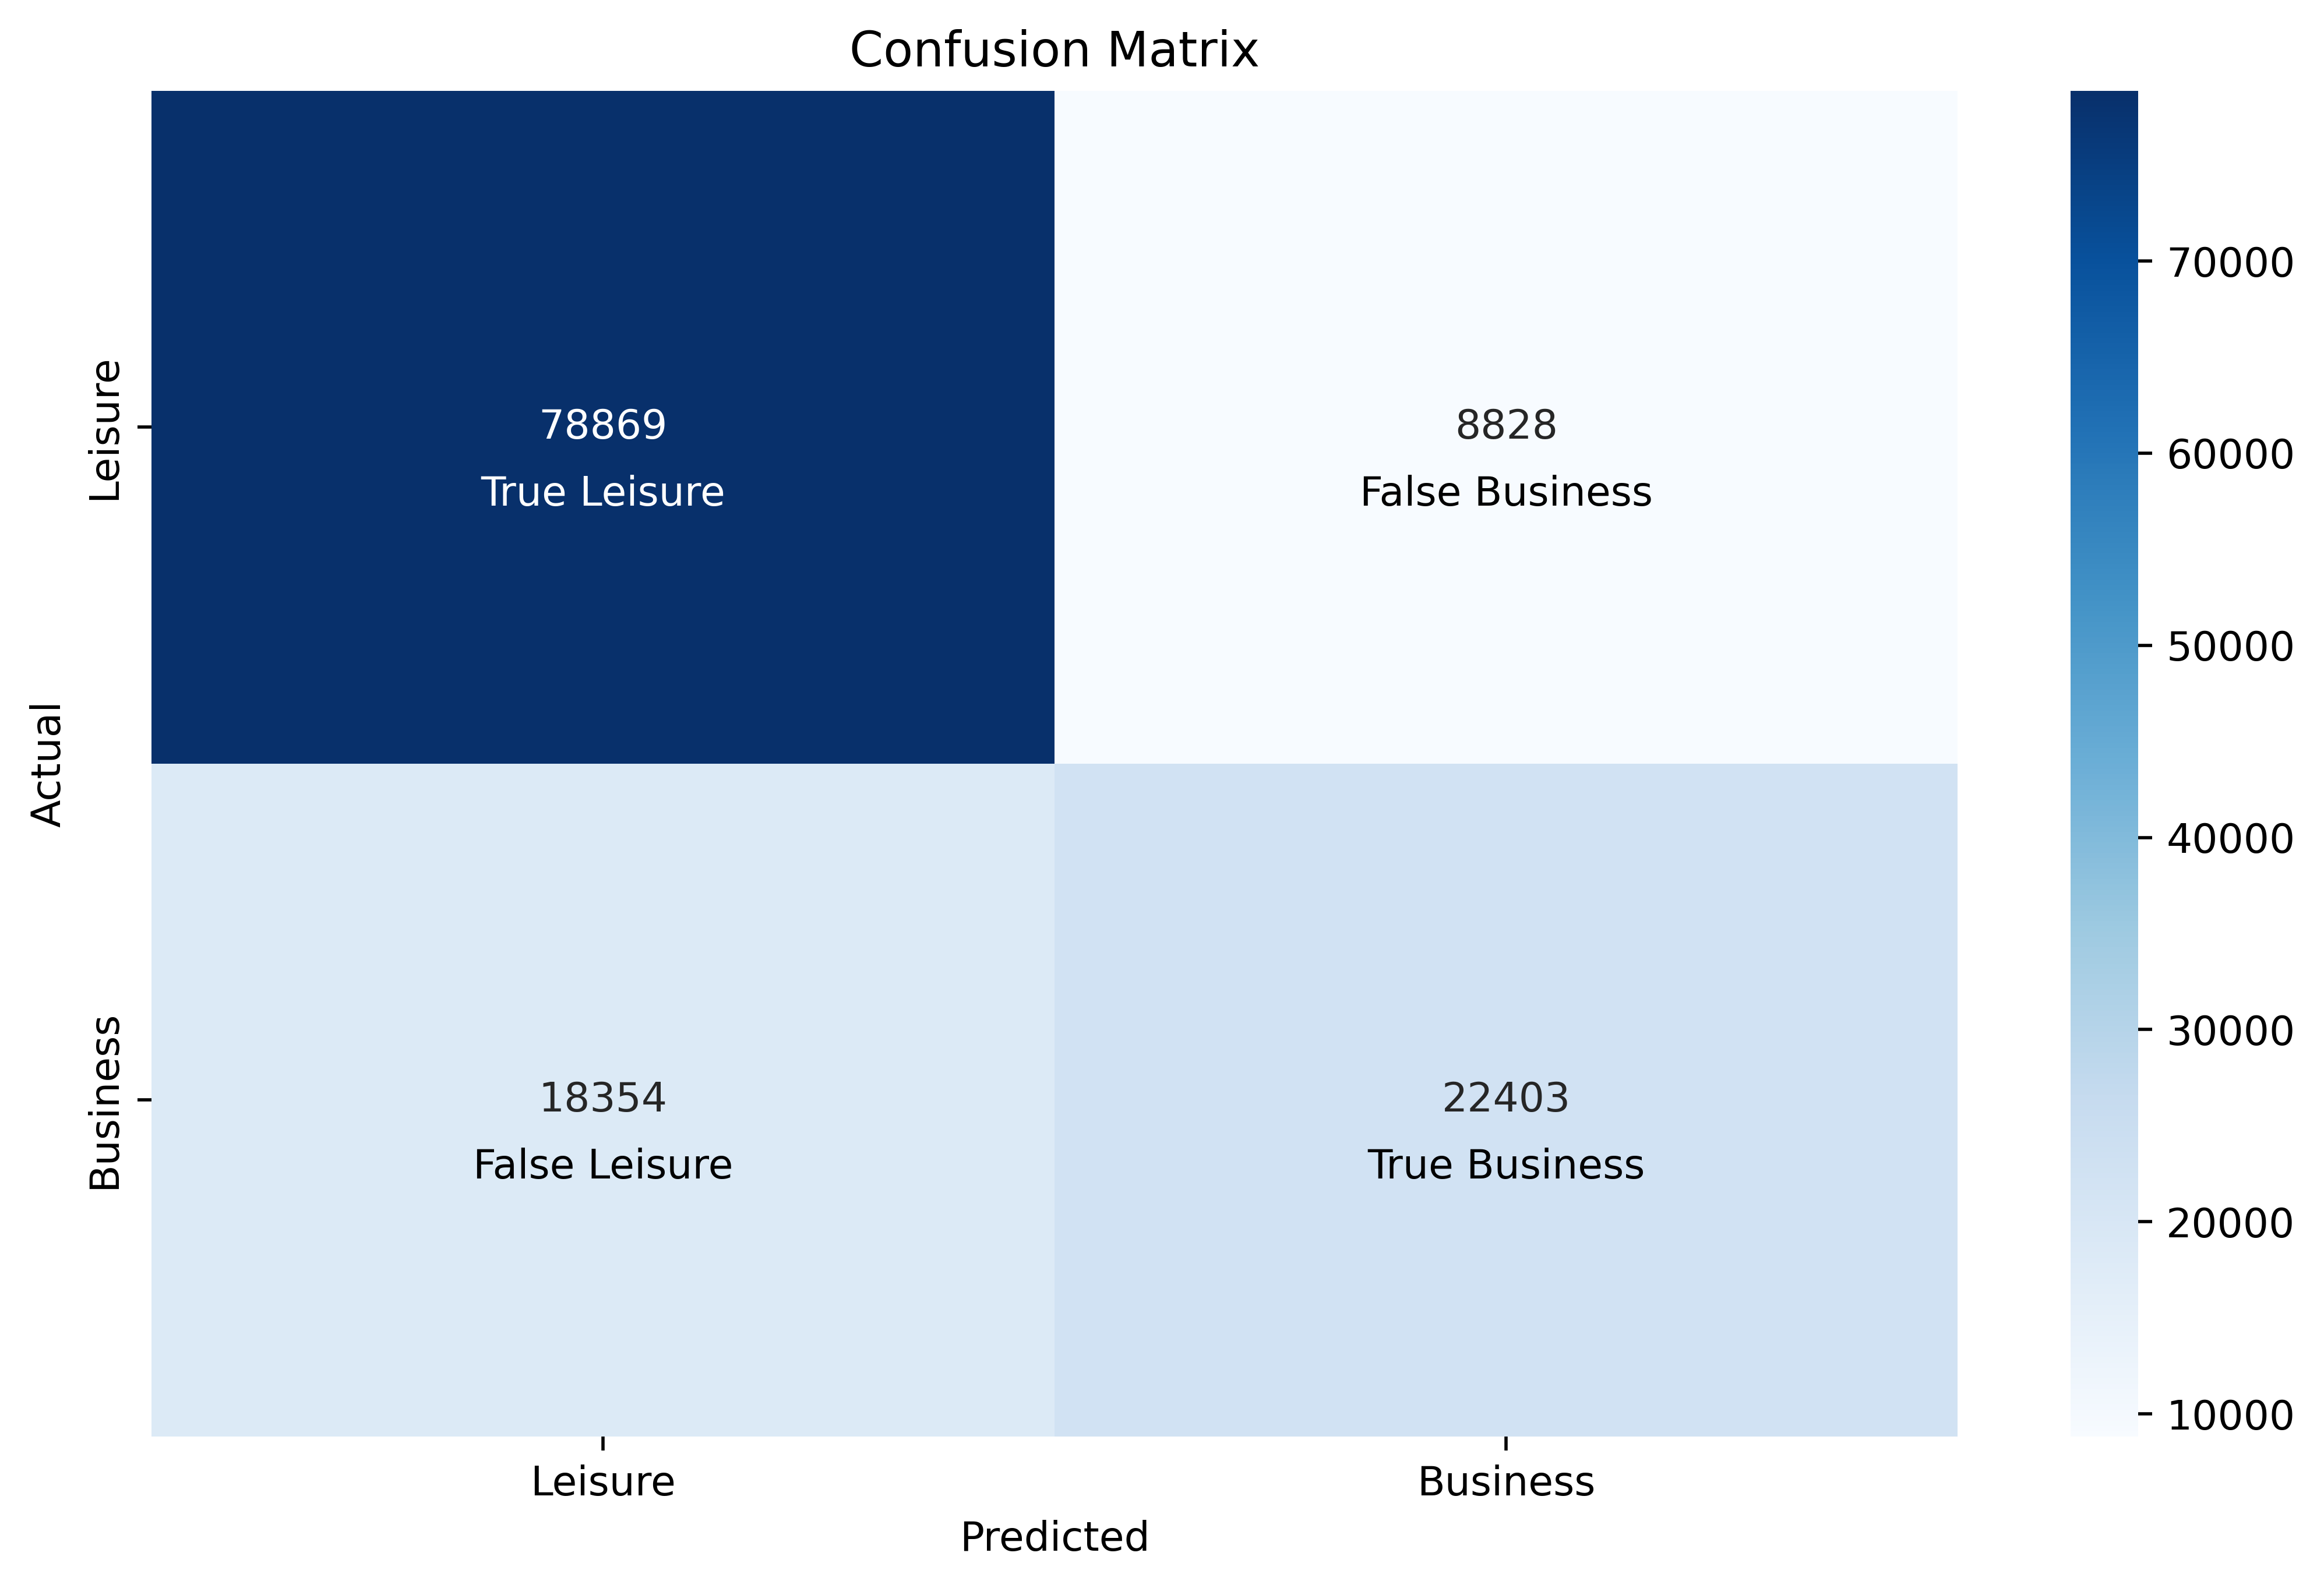

In [30]:
cm = confusion_matrix(y_test, prediction_data_lr)
plt.figure(figsize=(10, 6), dpi=500)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
             xticklabels=['Leisure', 'Business'], 
             yticklabels=['Leisure', 'Business'])
plt.text(0.5, 0.6, 'True Leisure', ha='center', va='center', color='white')
plt.text(1.5, 0.6, 'False Business', ha='center', va='center', color='black')
plt.text(0.5, 1.6, 'False Leisure', ha='center', va='center', color='black')
plt.text(1.5, 1.6, 'True Business', ha='center', va='center', color='black')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [31]:
predicted_counts = pd.Series(prediction_data_lr).value_counts(normalize=True) * 100
predicted_counts.index = ['Leisure', 'Business']
actual_distribution = {'Leisure': 68, 'Business': 32}
comparison_df = pd.DataFrame({
    'Predicted': predicted_counts,
    'Actual': actual_distribution.values()
}, index=actual_distribution.keys())
print("\nPredicted vs Actual Stay Purpose:", comparison_df)


Predicted vs Actual Stay Purpose:           Predicted  Actual
Leisure   75.687016      68
Business  24.312984      32


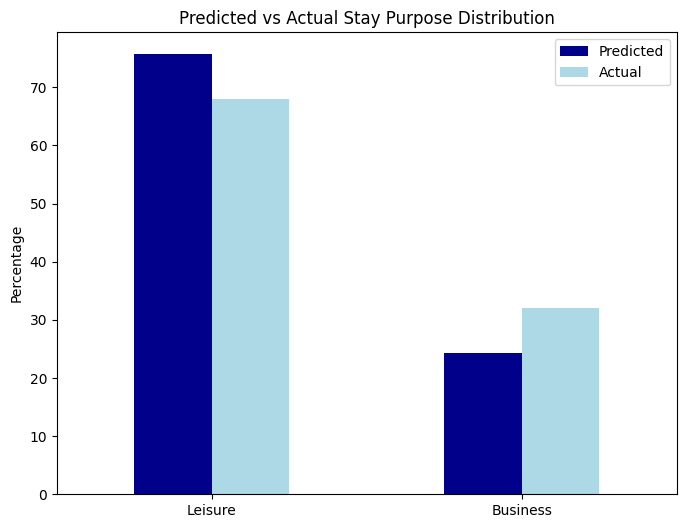

In [32]:
comparison_df.plot(kind='bar', figsize=(8, 6), color=['#00008B', '#ADD8E6'])
plt.title('Predicted vs Actual Stay Purpose Distribution')
plt.ylabel('Percentage')
plt.xlabel('') 
plt.xticks(rotation=0)
plt.show()

ROC AUC Score: 0.72


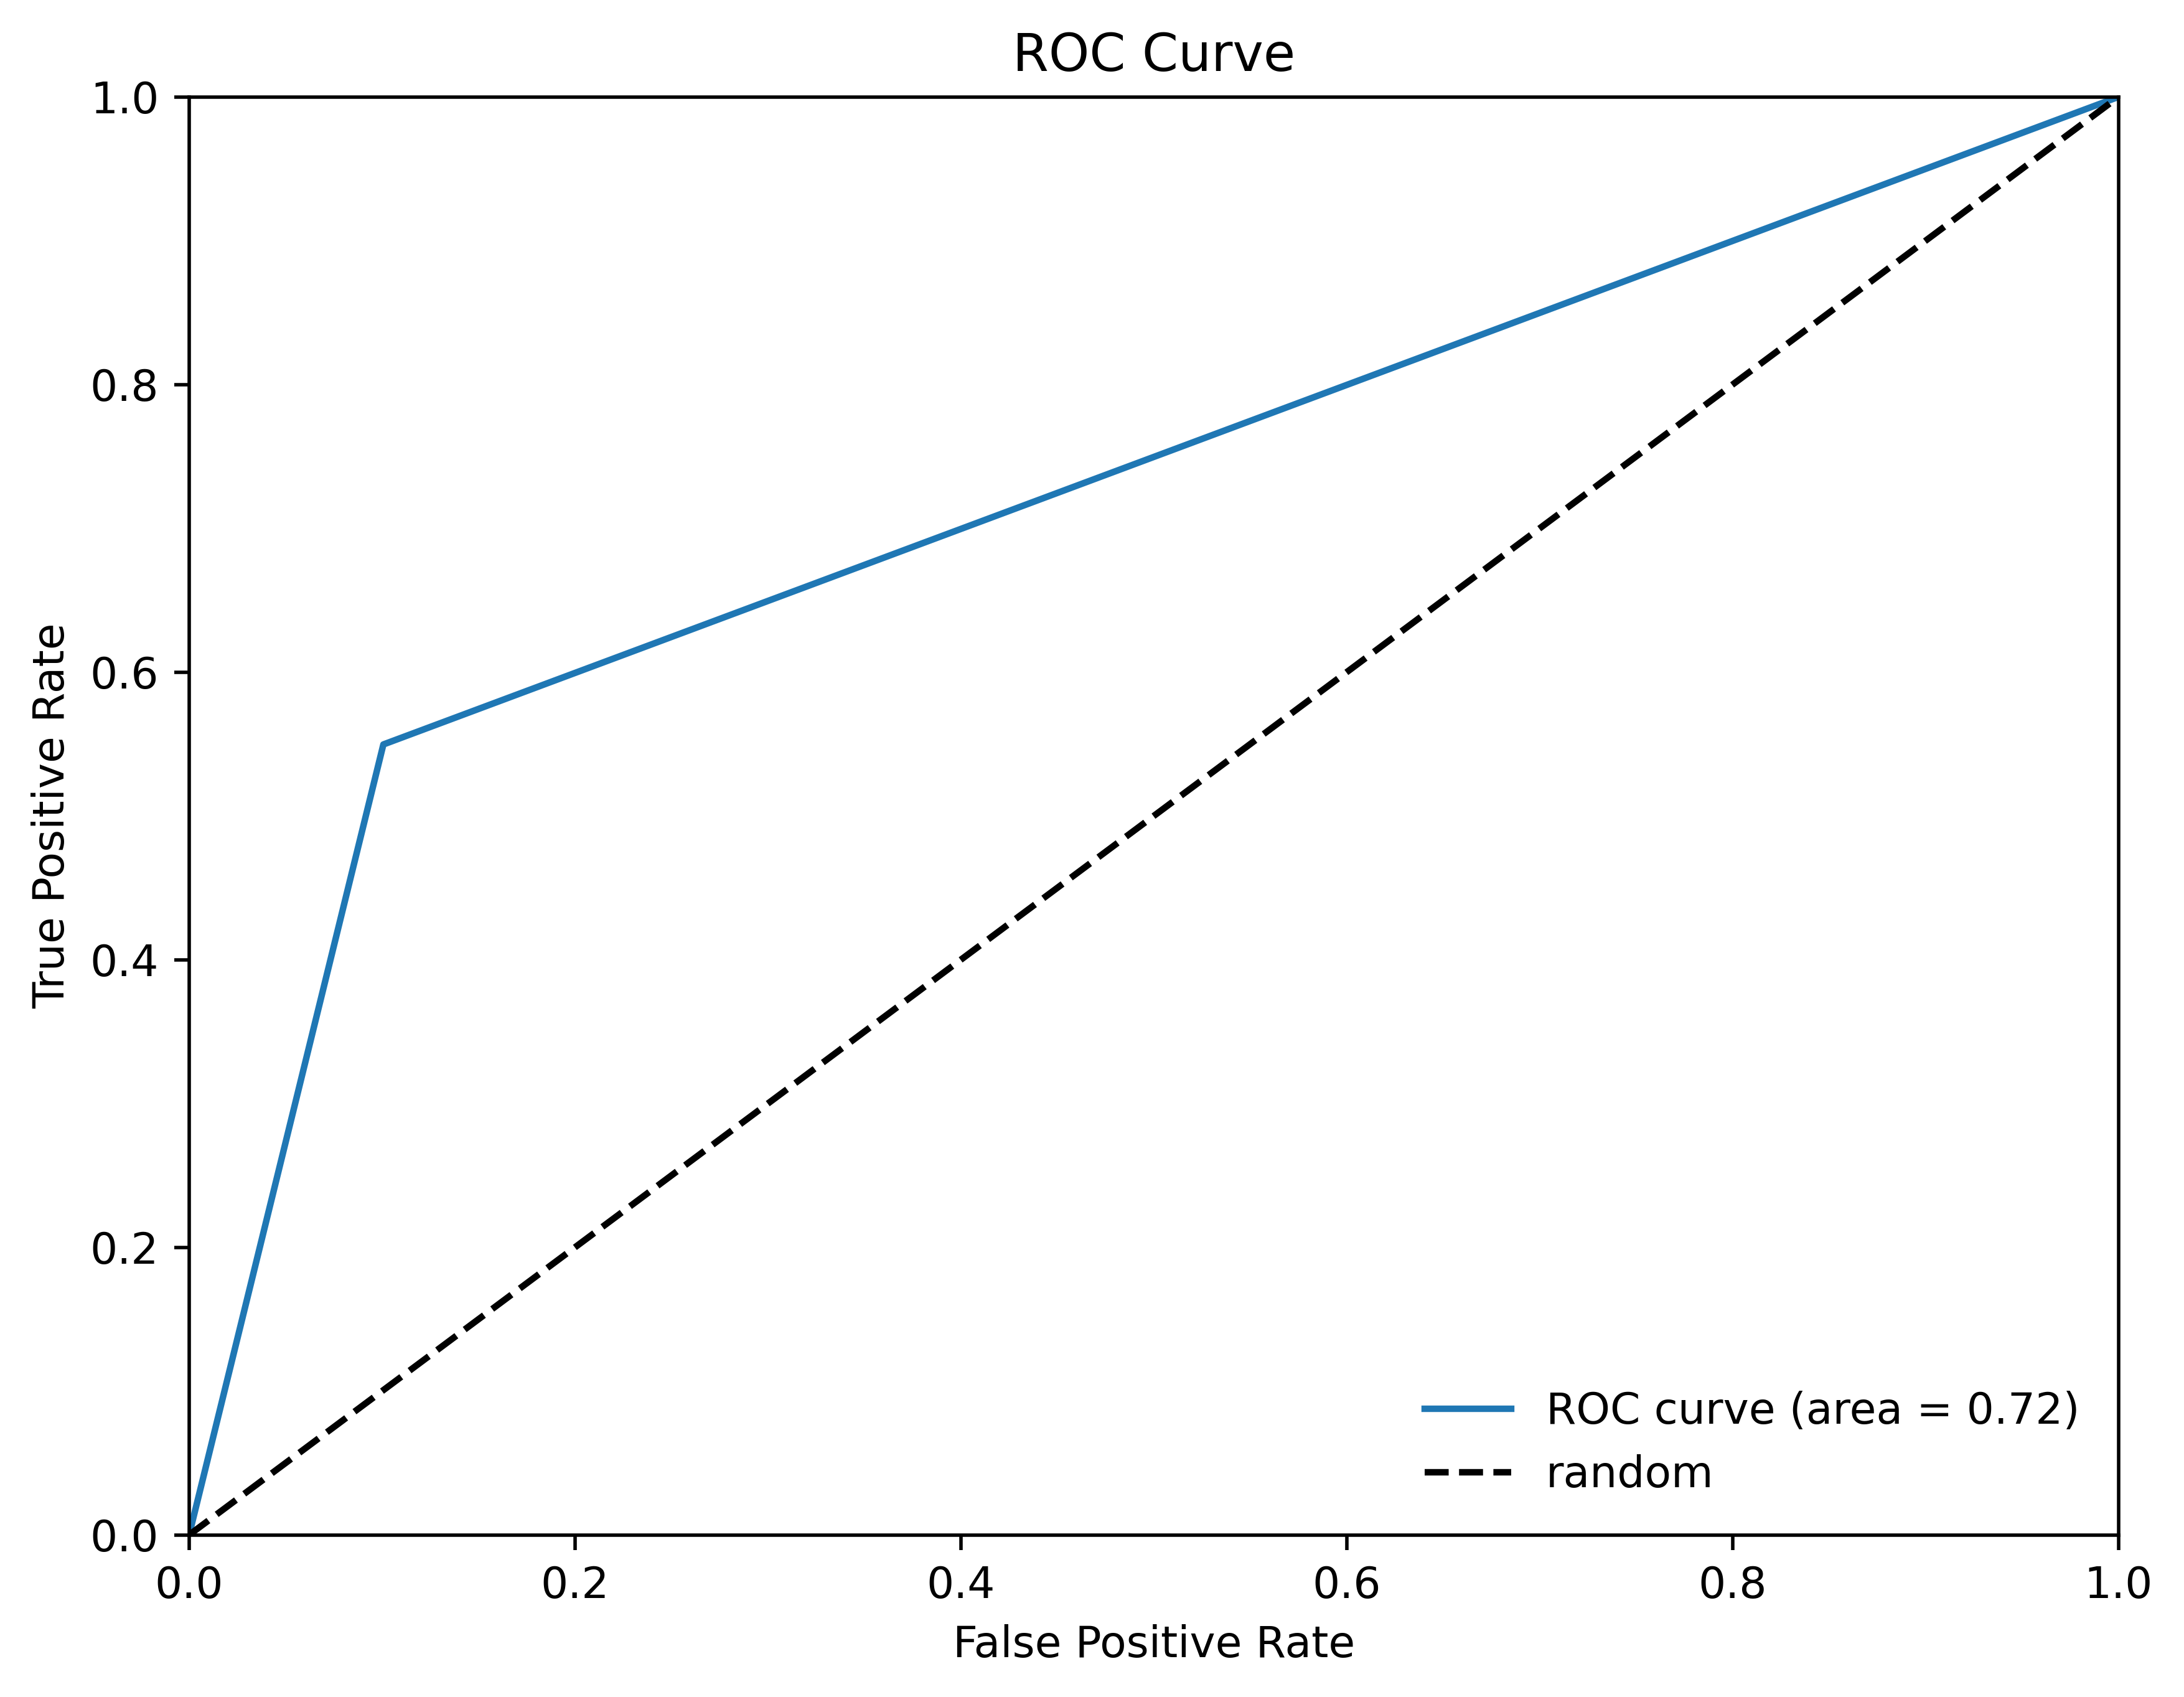

In [33]:
roc_auc = roc_auc_score(y_test, prediction_data_lr)
print(f"ROC AUC Score: {roc_auc:.2f}")
fpr, tpr, _ = roc_curve(y_test, prediction_data_lr)
plt.figure(figsize=(8, 6), dpi=500)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right", frameon=False)
plt.show()


## **Random Forest**

In [34]:
param_grid_rf = {
    'n_estimators': [200, 300],
    'max_depth': [10,],
    'min_samples_split': [10,15,20],
    'min_samples_leaf': [4,6,8,10],
    'max_features': ['sqrt'],     
    'bootstrap': [ False]  
}

model_rf = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(model_rf, param_grid_rf, cv=3, n_jobs=-1, verbose=1, scoring='accuracy')
grid_search_rf.fit(X_train, y_train)

prediction_data_rf = grid_search_rf.predict(X_test)
train_accuracy_rf = accuracy_score(y_train, grid_search_lr.predict(X_train))
test_accuracy_rf = accuracy_score(y_test, prediction_data_rf)

print("Best parameters found: ", grid_search_rf.best_params_)
print("Best cross-validation accuracy: {:.3f}".format(grid_search_rf.best_score_))
print("Training accuracy: {:.3f}".format(train_accuracy_rf))
print("Test accuracy: {:.3f}".format(test_accuracy_rf))

if train_accuracy_rf < test_accuracy_rf and test_accuracy_rf < grid_search_lr.best_score_:
    print("Underfitting: The model may be too simple for the data.")
elif train_accuracy_rf > test_accuracy_rf:
    print("Overfitting: The model may be overfitting to the training data.")
else:
    print("Good fit: The model seems to generalize well.")


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best parameters found:  {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.819
Training accuracy: 0.790
Test accuracy: 0.816
Good fit: The model seems to generalize well.


In [35]:
print("Classification report:", classification_report(y_test, prediction_data_rf))

Classification report:               precision    recall  f1-score   support

           0       0.84      0.91      0.87     87697
           1       0.76      0.62      0.68     40757

    accuracy                           0.82    128454
   macro avg       0.80      0.76      0.78    128454
weighted avg       0.81      0.82      0.81    128454



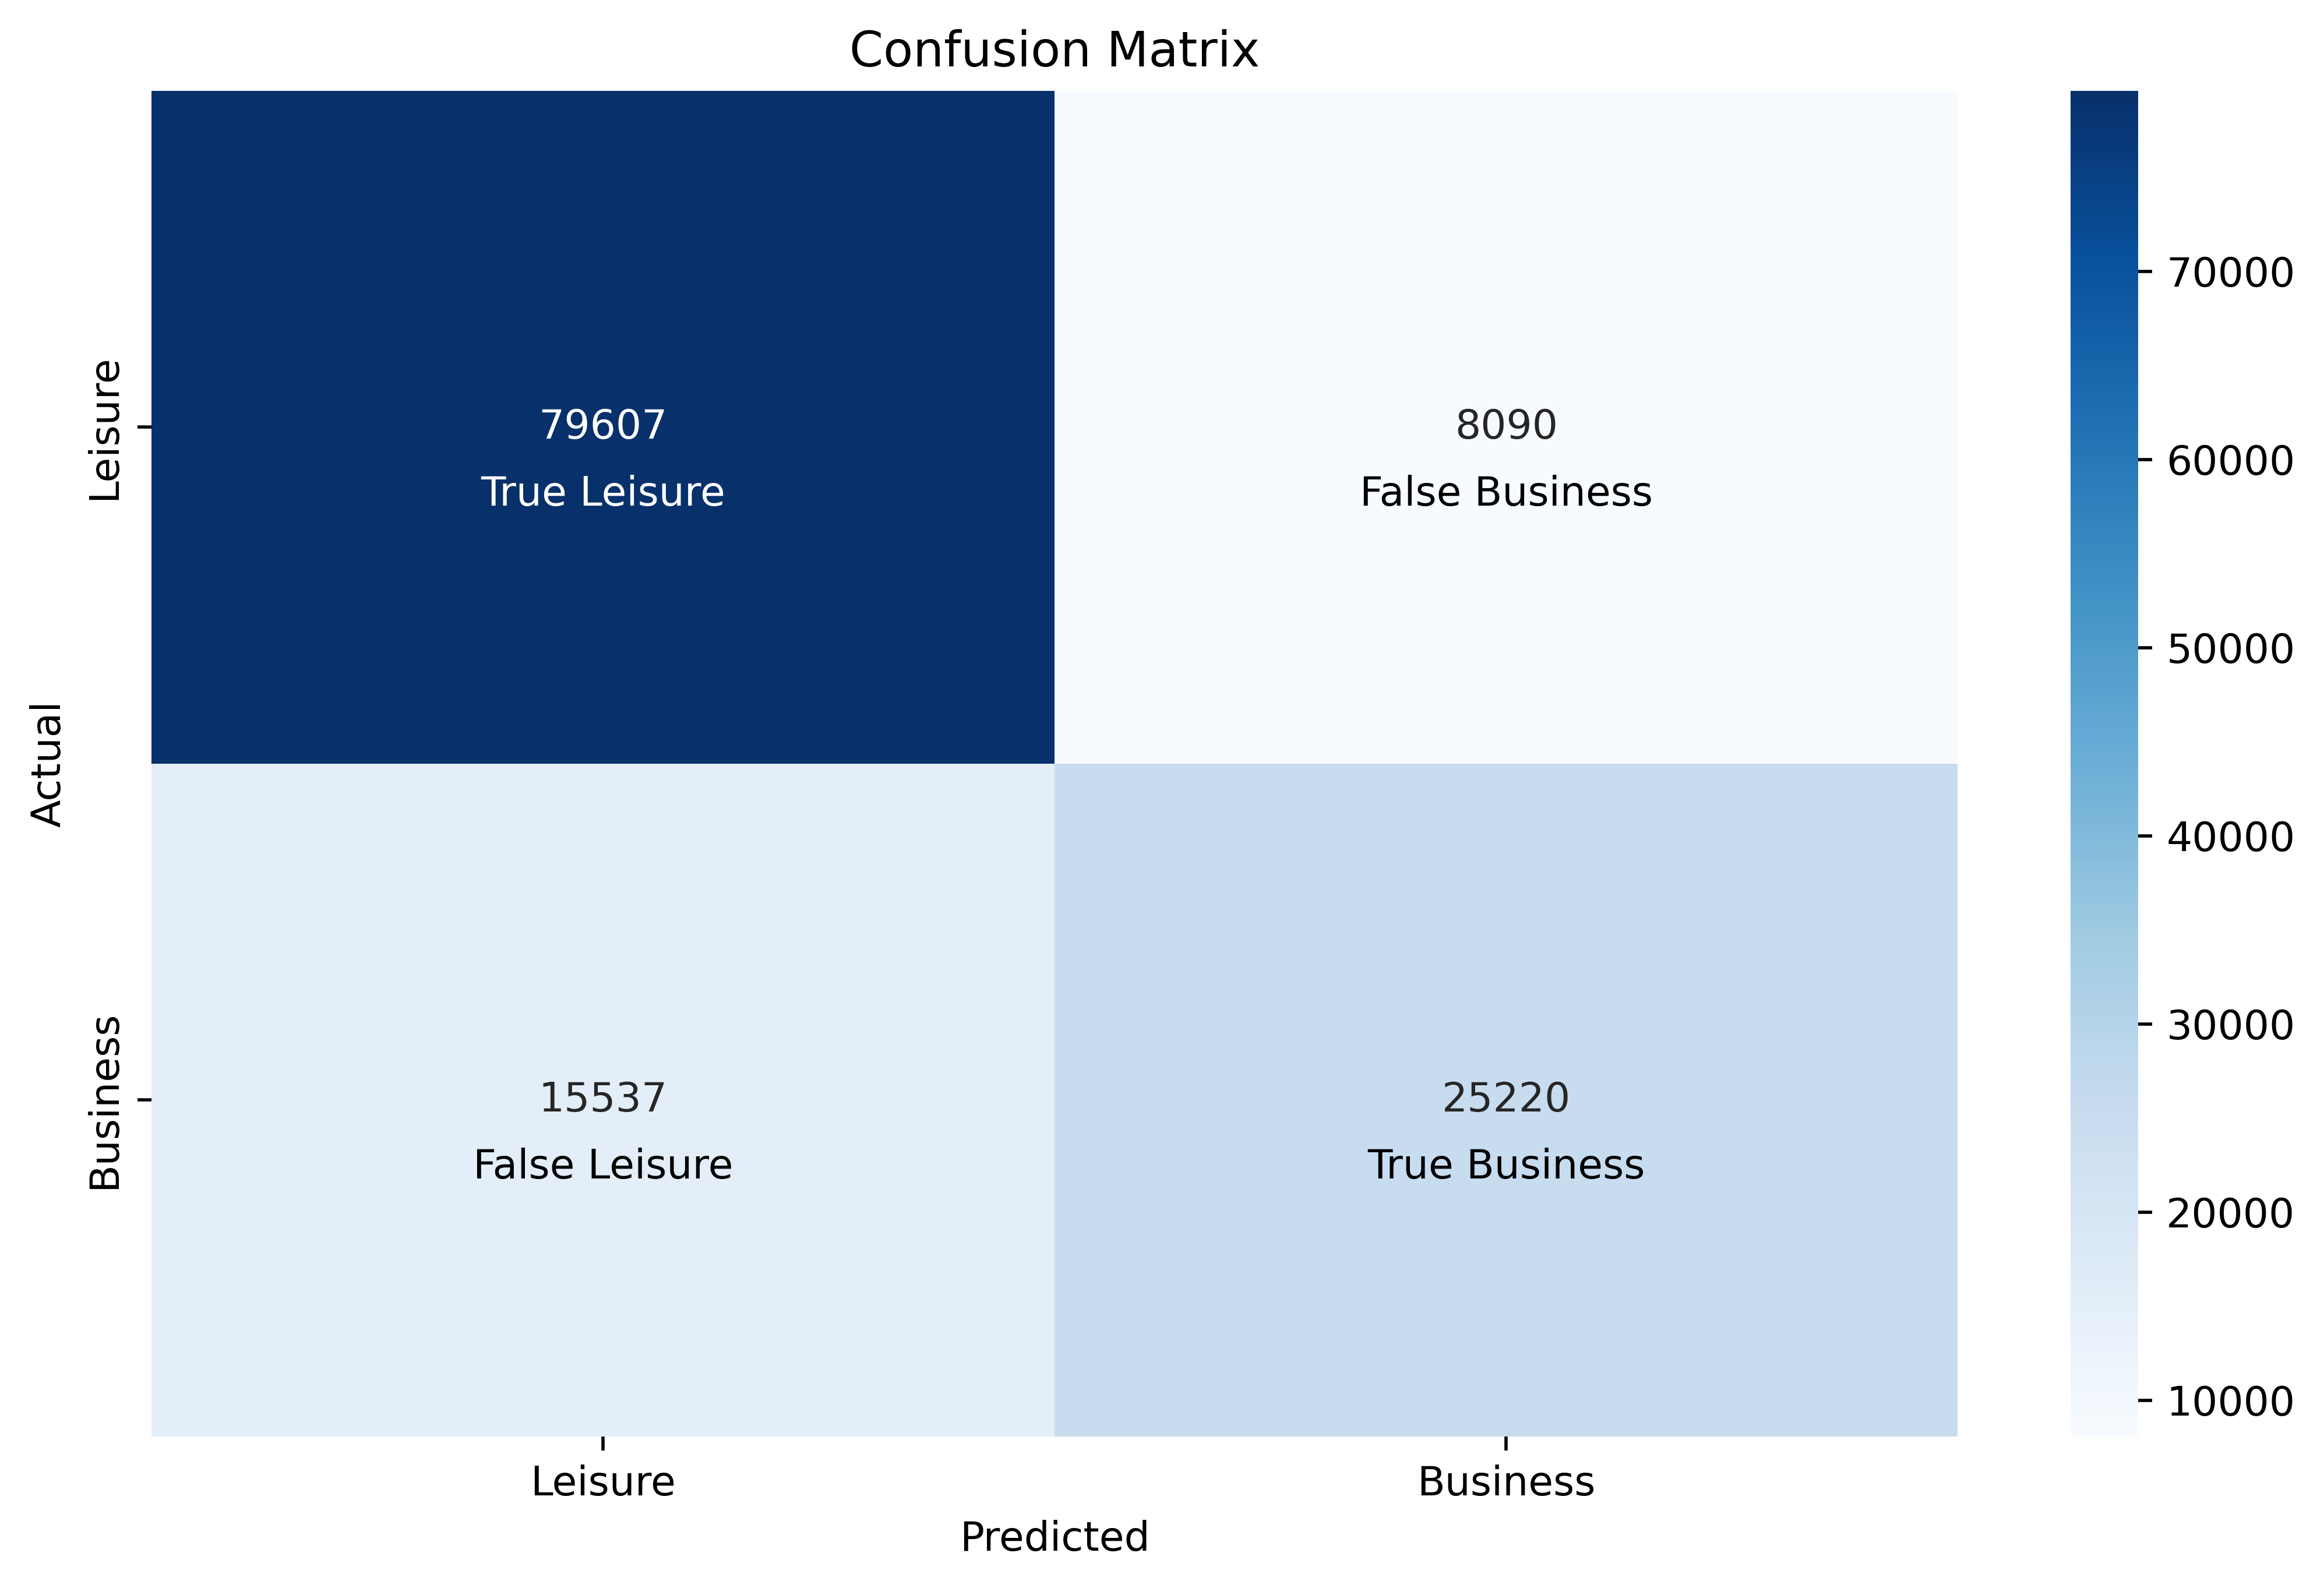

In [36]:
cm = confusion_matrix(y_test, prediction_data_rf)
plt.figure(figsize=(10, 6), dpi=500)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
             xticklabels=['Leisure', 'Business'], 
             yticklabels=['Leisure', 'Business'])
plt.text(0.5, 0.6, 'True Leisure', ha='center', va='center', color='white')
plt.text(1.5, 0.6, 'False Business', ha='center', va='center', color='black')
plt.text(0.5, 1.6, 'False Leisure', ha='center', va='center', color='black')
plt.text(1.5, 1.6, 'True Business', ha='center', va='center', color='black')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [37]:
predicted_counts = pd.Series(prediction_data_rf).value_counts(normalize=True) * 100
predicted_counts.index = ['Leisure', 'Business']
actual_distribution = {'Leisure': 68, 'Business': 32}
comparison_df = pd.DataFrame({
    'Predicted': predicted_counts,
    'Actual': actual_distribution.values()
}, index=actual_distribution.keys())
print("\nPredicted vs Actual Stay Purpose:", comparison_df)


Predicted vs Actual Stay Purpose:           Predicted  Actual
Leisure   74.068538      68
Business  25.931462      32


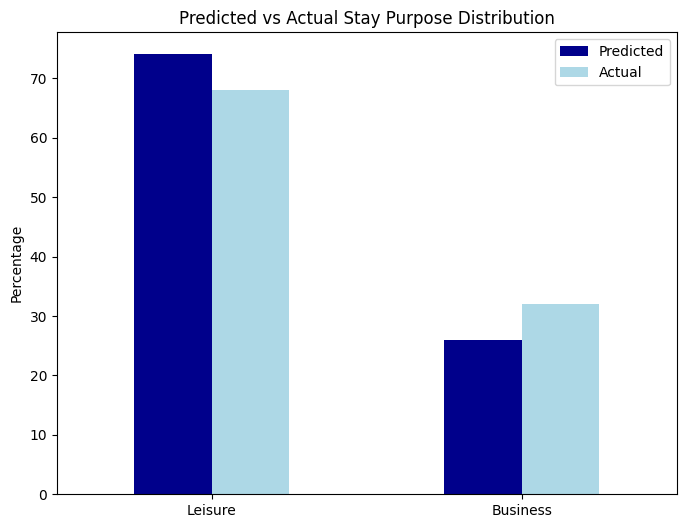

In [38]:
comparison_df.plot(kind='bar', figsize=(8, 6), color=['#00008B', '#ADD8E6'])
plt.title('Predicted vs Actual Stay Purpose Distribution')
plt.ylabel('Percentage')
plt.xlabel('') 
plt.xticks(rotation=0)
plt.show()

ROC AUC Score: 0.76


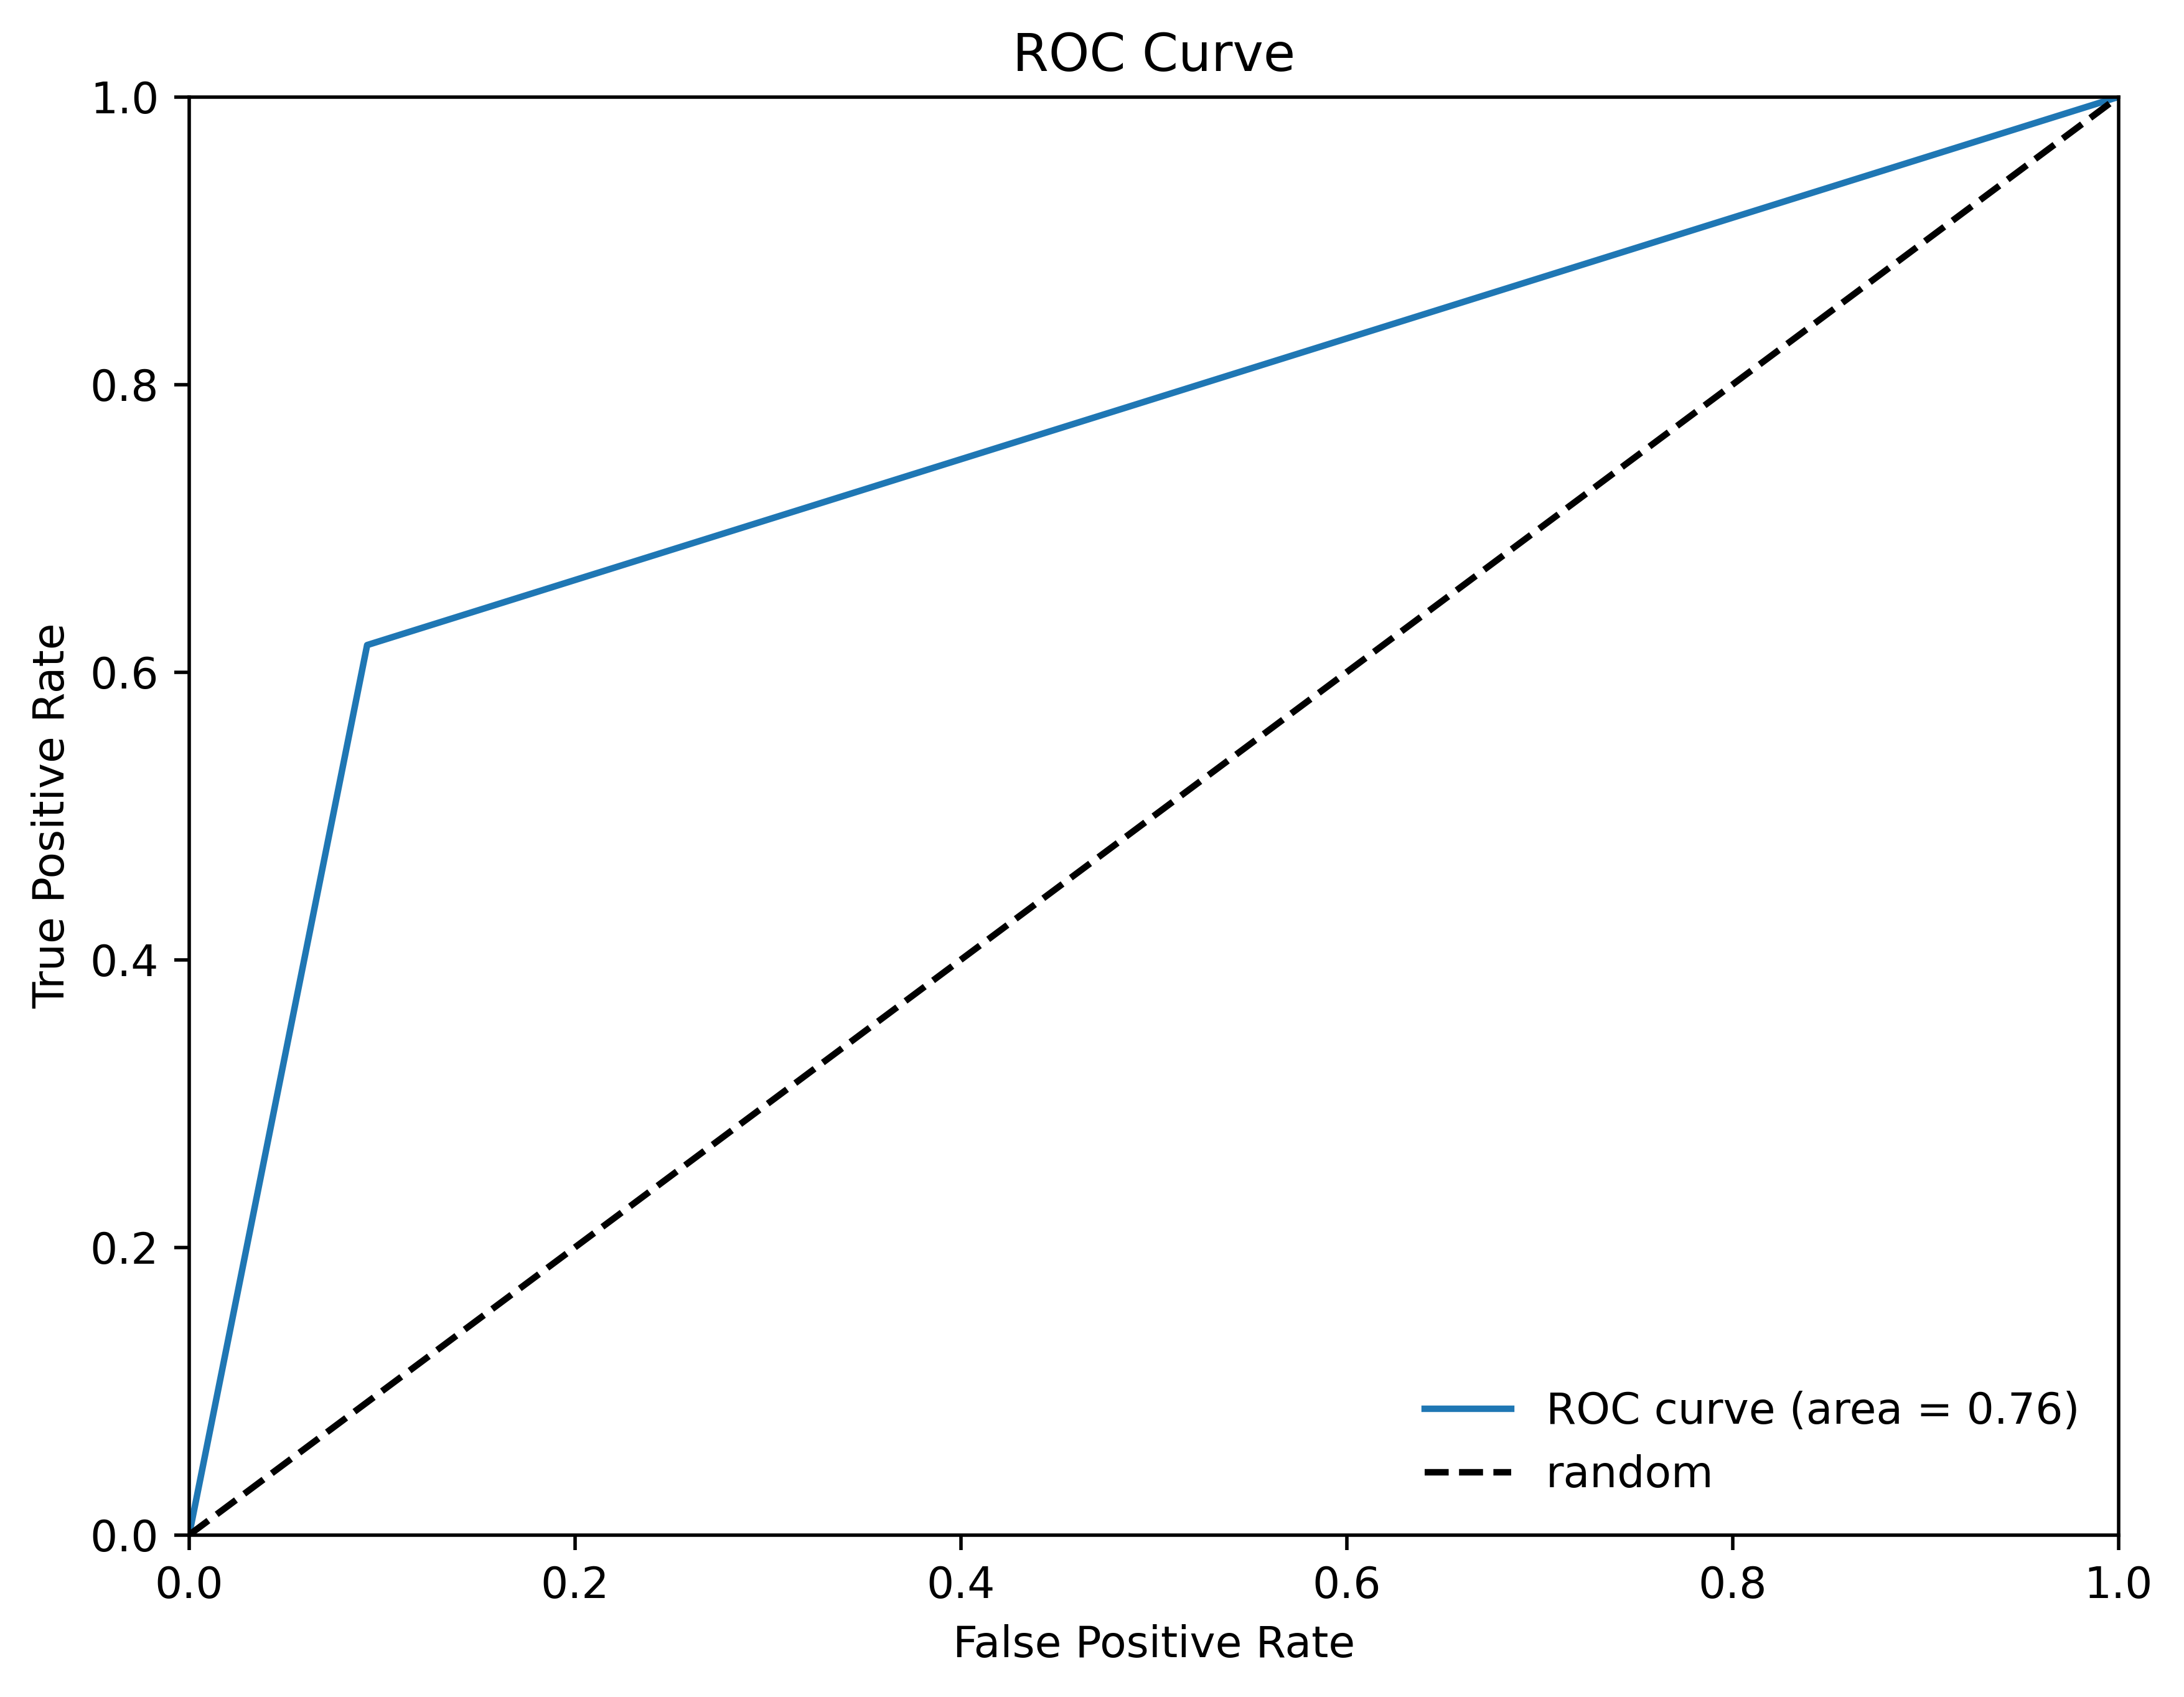

In [39]:
roc_auc = roc_auc_score(y_test, prediction_data_rf)
print(f"ROC AUC Score: {roc_auc:.2f}")
fpr, tpr, _ = roc_curve(y_test, prediction_data_rf)
plt.figure(figsize=(8, 6), dpi=500)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right", frameon=False)
plt.show()


## **Gradient Boosting**

In [40]:
param_grid = {
    'n_estimators': [100],     
    'learning_rate': [ 0.1, 0.2],  
    'max_depth': [3, 4],   
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1], 
    'subsample': [0.8, 0.9],  
    'max_features': ['sqrt']  
}

grid_search_gb = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid, cv=3, n_jobs=-1, verbose=1, scoring='accuracy')
grid_search_gb.fit(X_train, y_train)
predictions_gb = grid_search_gb.predict(X_test)

train_accuracy_gb = accuracy_score(y_train, grid_search_gb.predict(X_train))
test_accuracy_gb = accuracy_score(y_test, predictions_gb)

print("Best parameters found: ", grid_search_gb.best_params_)
print("Best cross-validation accuracy: {:.3f}".format(grid_search_gb.best_score_))
print("Training accuracy: {:.3f}".format(train_accuracy_gb))
print("Test accuracy: {:.3f}".format(test_accuracy_gb))

if train_accuracy_gb < test_accuracy_gb and test_accuracy_gb < grid_search_lr.best_score_:
    print("Underfitting: The model may be too simple for the data.")
elif train_accuracy_gb > test_accuracy_gb:
    print("Overfitting: The model may be overfitting to the training data.")
else:
    print("Good fit: The model seems to generalize well.")

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters found:  {'learning_rate': 0.2, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100, 'subsample': 0.9}
Best cross-validation accuracy: 0.824
Training accuracy: 0.825
Test accuracy: 0.821
Overfitting: The model may be overfitting to the training data.


In [41]:
print("Classification report:", classification_report(y_test, predictions_gb))

Classification report:               precision    recall  f1-score   support

           0       0.84      0.91      0.87     87697
           1       0.76      0.64      0.69     40757

    accuracy                           0.82    128454
   macro avg       0.80      0.77      0.78    128454
weighted avg       0.82      0.82      0.82    128454



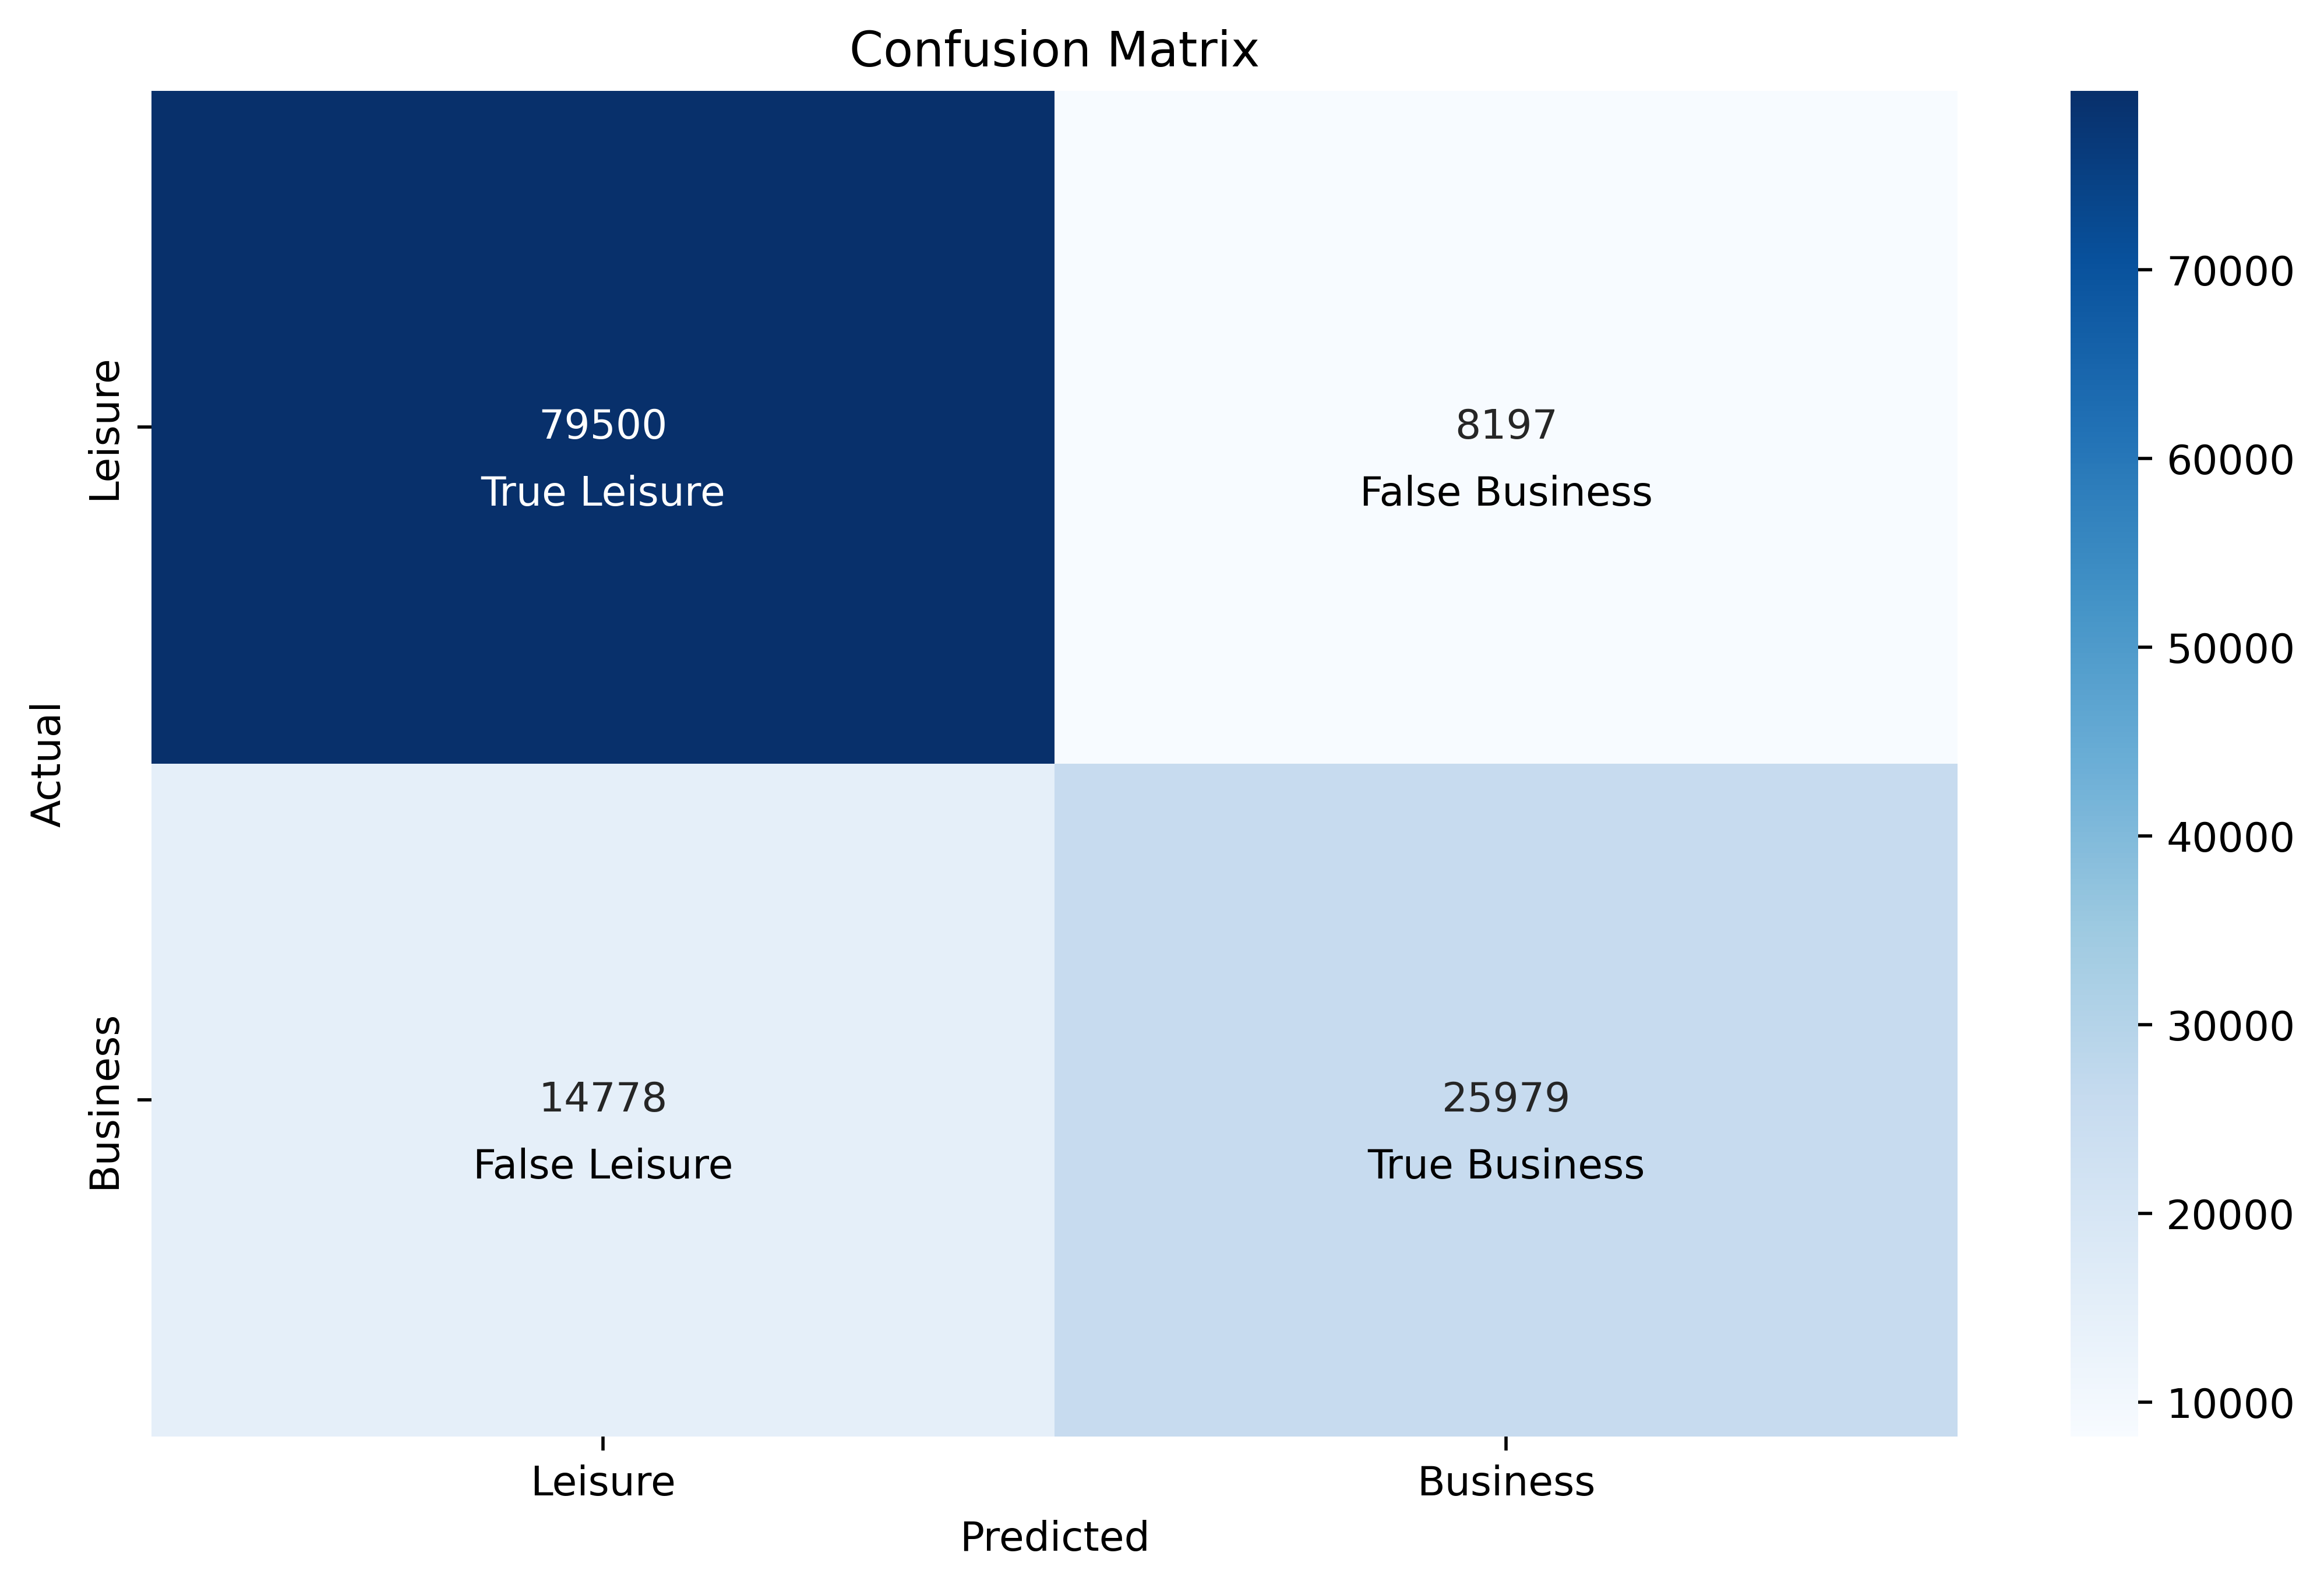

In [42]:
cm = confusion_matrix(y_test, predictions_gb)
plt.figure(figsize=(10, 6), dpi=500)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
             xticklabels=['Leisure', 'Business'], 
             yticklabels=['Leisure', 'Business'])
plt.text(0.5, 0.6, 'True Leisure', ha='center', va='center', color='white')
plt.text(1.5, 0.6, 'False Business', ha='center', va='center', color='black')
plt.text(0.5, 1.6, 'False Leisure', ha='center', va='center', color='black')
plt.text(1.5, 1.6, 'True Business', ha='center', va='center', color='black')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [43]:
predicted_counts = pd.Series(predictions_gb).value_counts(normalize=True) * 100
predicted_counts.index = ['Leisure', 'Business']
actual_distribution = {'Leisure': 68, 'Business': 32}
comparison_df = pd.DataFrame({
    'Predicted': predicted_counts,
    'Actual': actual_distribution.values()
}, index=actual_distribution.keys())
print("\nPredicted vs Actual Stay Purpose:", comparison_df)


Predicted vs Actual Stay Purpose:           Predicted  Actual
Leisure   73.394367      68
Business  26.605633      32


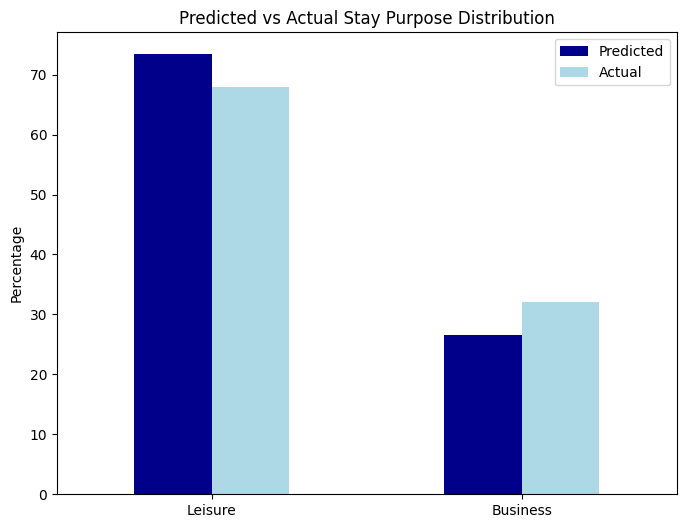

In [44]:
comparison_df.plot(kind='bar', figsize=(8, 6), color=['#00008B', '#ADD8E6'])
plt.title('Predicted vs Actual Stay Purpose Distribution')
plt.ylabel('Percentage')
plt.xlabel('') 
plt.xticks(rotation=0)
plt.show()

ROC AUC Score: 0.77


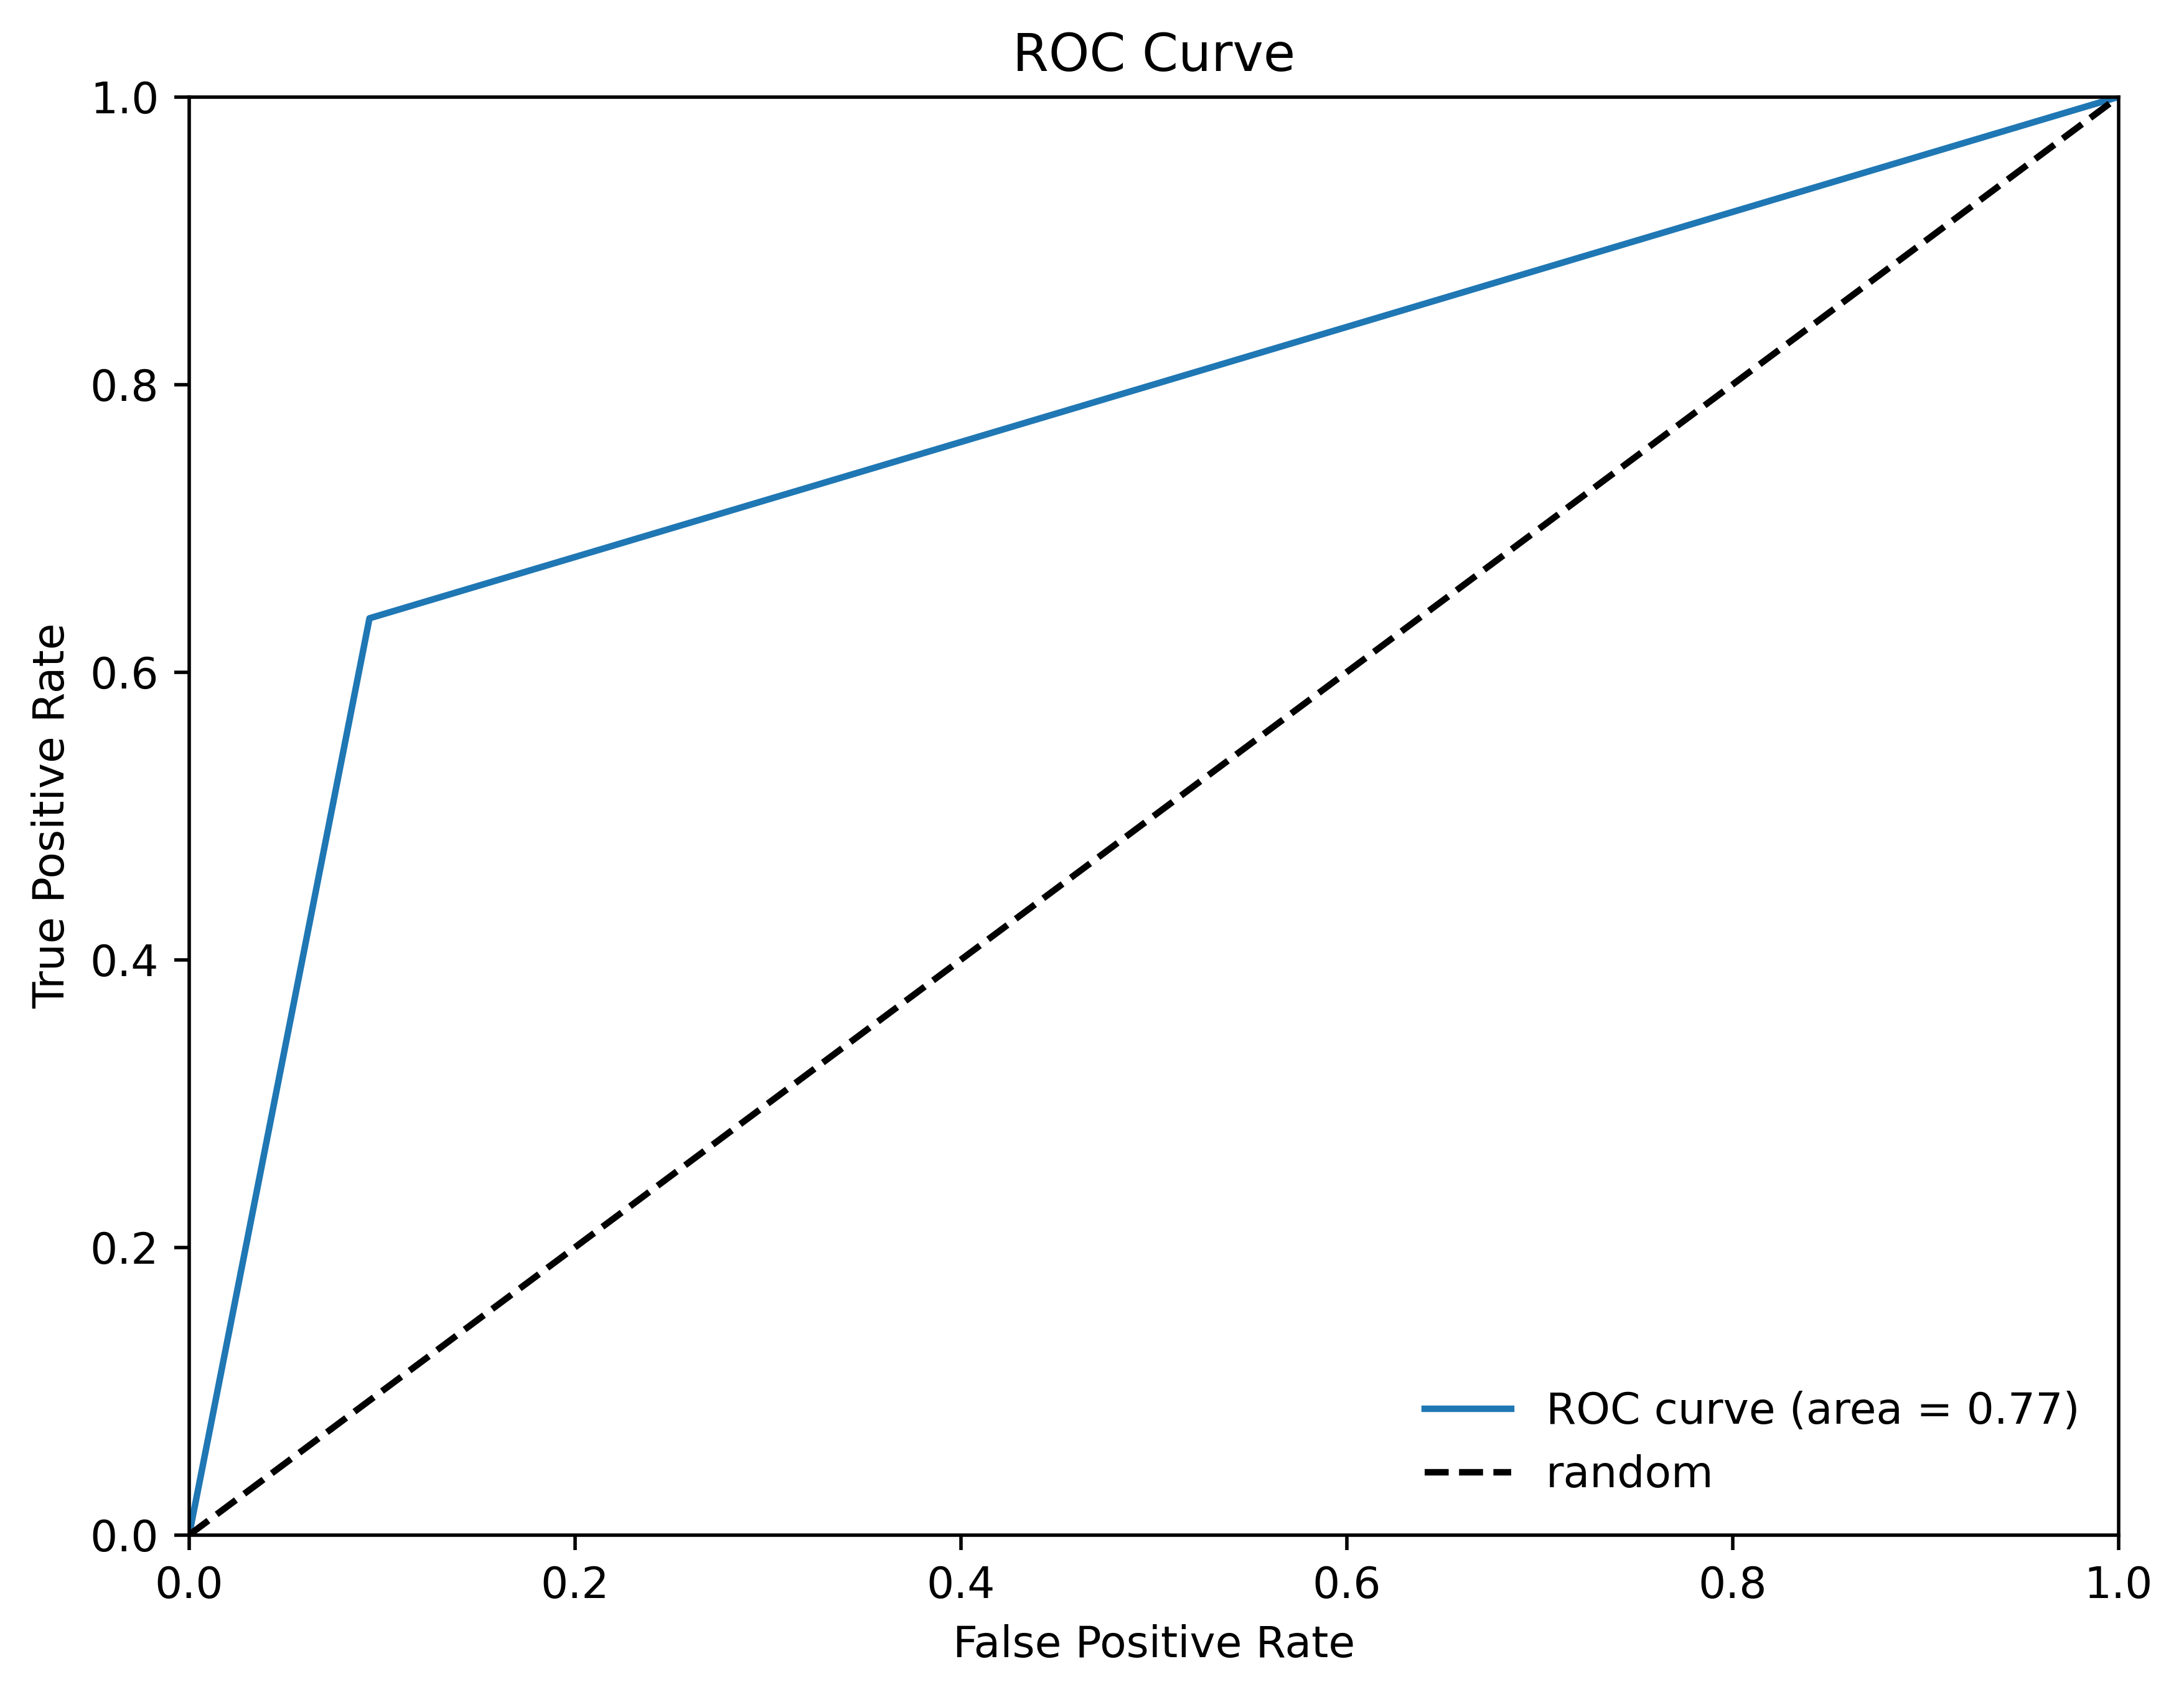

In [45]:
roc_auc = roc_auc_score(y_test, predictions_gb)
print(f"ROC AUC Score: {roc_auc:.2f}")
fpr, tpr, _ = roc_curve(y_test, predictions_gb)
plt.figure(figsize=(8, 6), dpi=500)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right", frameon=False)
plt.show()
